In [32]:
# @title Running in Colab

from IPython.display import HTML, Javascript, display

display(
    HTML(
        """<a href="https://colab.research.google.com/github/evan-lloyd/mechinterp-experiments/blob/main/tiny_stories_sae/e2e_demo.ipynb" target="_blank" id="colab-button">
            Run this notebook in Google Colab
        </a>"""
    )
)
display(
    Javascript("""
        setTimeout(() => {
            if(typeof google.colab != "undefined") {
                document.querySelector("#colab-button").remove()
            }
        }, 0);
        """)
)

<IPython.core.display.Javascript object>

# Initialize notebook environment


In [33]:
import os

# If we're running in Colab, we need to clone the non-notebook source from git.
if os.getenv("COLAB_RELEASE_TAG") and not os.path.isdir(
    "/content/mechinterp-experiments"
):
    ip = get_ipython()  #  pyright: ignore[reportUndefinedVariable]
    ip.run_cell_magic(
        "bash",
        "",
        """
    git clone --filter=blob:none --no-checkout https://github.com/evan-lloyd/mechinterp-experiments.git
    cd mechinterp-experiments
    git sparse-checkout init --no-cone
    echo "/tiny_stories_sae" > .git/info/sparse-checkout
    git checkout
  """,
    )
    ip.run_line_magic("cd", "mechinterp-experiments/tiny_stories_sae")
else:
    print("Already cloned source, or not running in Colab.")

# Nice for dev, but not needed for Colab.
try:
    # This uses a library called jurigged to hot-reload code when it is changed.
    # For reasons I've never been able to figure out, the IPython %autoreload magic
    # completely fails to work with the kind of structure I use in this notebook.
    import tiny_stories_sae._autoreload
except Exception:
    pass

Already cloned source, or not running in Colab.


In [34]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

# Tweak TRAINING_BATCH_SIZE for your hardware if necessary
if torch.cuda.is_available():
    TRAINING_DEVICE = "cuda"
    TRAINING_BATCH_SIZE = 16
    E2E_BATCH_SIZE = 4
elif torch.mps.is_available():
    TRAINING_DEVICE = "mps"
    TRAINING_BATCH_SIZE = 8
    E2E_BATCH_SIZE = 2
else:
    TRAINING_DEVICE = "cpu"
    TRAINING_BATCH_SIZE = 8
    E2E_BATCH_SIZE = 2

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
training_dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)
validation_dataset = load_dataset(
    "roneneldan/TinyStories", split="validation", streaming=True
)
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-33M").to(
    TRAINING_DEVICE
)

print(model)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_feat

In [35]:
# Caches model activations to these directories; modify if necessary, or set to None to disable.
# These take up ~16GB and ~1.5GB respectively, but will save a fair bit of time when running
# the notebook, since they can be re-used across all methods we're comparing.
TRAINING_CACHE_DIR = None
VALIDATION_CACHE_DIR = None
# TRAINING_CACHE_DIR = ".training_cache"
# VALIDATION_CACHE_DIR = ".validation_cache"
NUM_TRAINING_TOKENS = int(1e6)
EVAL_INTERVAL = int(1e4)
NUM_VALIDATION_TOKENS = int(1e5)
D_MODEL = model.config.hidden_size
D_SAE = D_MODEL * 4
TOKENIZER_BATCH_SIZE = 128

# Train SAEs for comparison


In [36]:
from tiny_stories_sae.sae import SAE
from tiny_stories_sae.training import TrainingConfig, TrainingMethod, train

saes = {
    method: {
        layer: SAE(
            D_MODEL,
            D_SAE,
            device=model.device,
            kind="topk",
            topk=100,
        )
        for layer in range(model.config.num_layers)
    }
    for method in TrainingMethod
    # We will clone these from the corresponding pre-fine-tuned method to save time
    if method not in (TrainingMethod.finetuned, TrainingMethod.next_layer_finetuned)
}


def linear_decay(frac_trained: float):
    return 1.0 - frac_trained


training_config = {
    method: TrainingConfig(
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        training_batch_size=TRAINING_BATCH_SIZE,
        e2e_batch_size=E2E_BATCH_SIZE,
        num_train_tokens=NUM_TRAINING_TOKENS,
        eval_interval=EVAL_INTERVAL,
        train_layers=list(range(model.config.num_layers)),
        lr=1e-3,
        finetune_lr_schedule=linear_decay,  # per Karvonen (2025)
        use_downstream_saes=method
        in (TrainingMethod.next_layer, TrainingMethod.next_layer_finetuned),
        downstream_reconstruction_weight=1.0
        if method in (TrainingMethod.next_layer, TrainingMethod.next_layer_finetuned)
        else 0.0,
        reconstruction_weight=1.0,
        balance_reconstruction_losses=method
        in (TrainingMethod.next_layer, TrainingMethod.next_layer_finetuned),
        method=method,
        finetune_fraction=0.10
        if method in (TrainingMethod.finetuned, TrainingMethod.next_layer_finetuned)
        else None,
    )
    for method in TrainingMethod
}

training_results = {}

In [37]:
import os

from tiny_stories_sae.training import build_cache

if TRAINING_CACHE_DIR and (
    not os.path.exists(TRAINING_CACHE_DIR) or not os.listdir(TRAINING_CACHE_DIR)
):
    build_cache(
        TRAINING_CACHE_DIR,
        model,
        tokenizer,
        training_dataset,
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        inference_batch_size=TRAINING_BATCH_SIZE,
        num_tokens=NUM_TRAINING_TOKENS,
    )

if VALIDATION_CACHE_DIR and (
    not os.path.exists(VALIDATION_CACHE_DIR) or not os.listdir(VALIDATION_CACHE_DIR)
):
    build_cache(
        VALIDATION_CACHE_DIR,
        model,
        tokenizer,
        validation_dataset,
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        inference_batch_size=TRAINING_BATCH_SIZE,
        num_tokens=NUM_VALIDATION_TOKENS,
    )

# Standard loss (current layer reconstruction error only)

In [38]:
from tiny_stories_sae.ops import clone_sae


# Save some time by initializing KL-fine-tuning SAEs when we hit the initial training threshold
def _maybe_clone_to_finetuned(num_tokens: int):
    if (
        TrainingMethod.finetuned in saes
        or num_tokens
        < (1.0 - training_config[TrainingMethod.finetuned].finetune_fraction)
        * training_config[TrainingMethod.finetuned].num_train_tokens
    ):
        return
    saes[TrainingMethod.finetuned] = {
        layer: clone_sae(sae) for layer, sae in saes[TrainingMethod.standard].items()
    }


training_results[TrainingMethod.standard] = train(
    model,
    tokenizer,
    saes[TrainingMethod.standard],
    training_dataset,
    training_config[TrainingMethod.standard],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
    post_step_hook=_maybe_clone_to_finetuned,
)

Layer 3

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/1000000 [00:00<?, ?it/s]

## Next-layer auxiliary loss (my method)


In [39]:
def _maybe_clone_to_next_layer_finetuned(num_tokens: int):
    if (
        TrainingMethod.next_layer_finetuned in saes
        or num_tokens
        < (1.0 - training_config[TrainingMethod.next_layer_finetuned].finetune_fraction)
        * training_config[TrainingMethod.next_layer_finetuned].num_train_tokens
    ):
        return
    saes[TrainingMethod.next_layer_finetuned] = {
        layer: clone_sae(sae) for layer, sae in saes[TrainingMethod.next_layer].items()
    }


training_results[TrainingMethod.next_layer] = train(
    model,
    tokenizer,
    saes[TrainingMethod.next_layer],
    training_dataset,
    training_config[TrainingMethod.next_layer],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
    post_step_hook=_maybe_clone_to_next_layer_finetuned,
)

Layer 3

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/1000000 [00:00<?, ?it/s]

# Next-layer with KL finetune

In [40]:
from tiny_stories_sae.ops import splice_training_trajectory

training_results[TrainingMethod.next_layer_finetuned] = train(
    model,
    tokenizer,
    saes[TrainingMethod.next_layer_finetuned],
    training_dataset,
    training_config[TrainingMethod.next_layer_finetuned],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=False,
    start_at_finetune=True,
)

# Since we cloned the pre-fine-tuning model, it has the same training trajectory up until
# finetuning starts.
training_results[TrainingMethod.next_layer_finetuned] = splice_training_trajectory(
    training_results[TrainingMethod.next_layer],
    training_results[TrainingMethod.next_layer_finetuned],
)

Layer 3

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/100000 [00:00<?, ?it/s]

## End-to-end training

Recreation of the method SAE_e2e+ds from

> Braun, Dan, Jordan Taylor, Nicholas Goldowsky-Dill, and Lee Sharkey. 2024. “Identifying Functionally Important Features with End-to-End Sparse Dictionary Learning.” arXiv [Cs.LG]. arXiv. http://arxiv.org/abs/2405.12241.


In [41]:
training_results[TrainingMethod.e2e] = train(
    model,
    tokenizer,
    saes[TrainingMethod.e2e],
    training_dataset,
    training_config[TrainingMethod.e2e],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/1000000 [00:00<?, ?it/s]

## KL fine-tuning

Recreation of the KL fine-tuning method from

> Karvonen, Adam. 2025. “Revisiting End-to-End Sparse Autoencoder Training: A Short Finetune Is All You Need.” arXiv [Cs.LG]. arXiv. http://arxiv.org/abs/2503.17272.


In [42]:
training_results[TrainingMethod.finetuned] = train(
    model,
    tokenizer,
    saes[TrainingMethod.finetuned],
    training_dataset,
    training_config[TrainingMethod.finetuned],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=False,
    start_at_finetune=True,
)

training_results[TrainingMethod.finetuned] = splice_training_trajectory(
    training_results[TrainingMethod.standard],
    training_results[TrainingMethod.finetuned],
)

Layer 3

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/100000 [00:00<?, ?it/s]

# Evaluations and comparisons


## Train-time evaluations

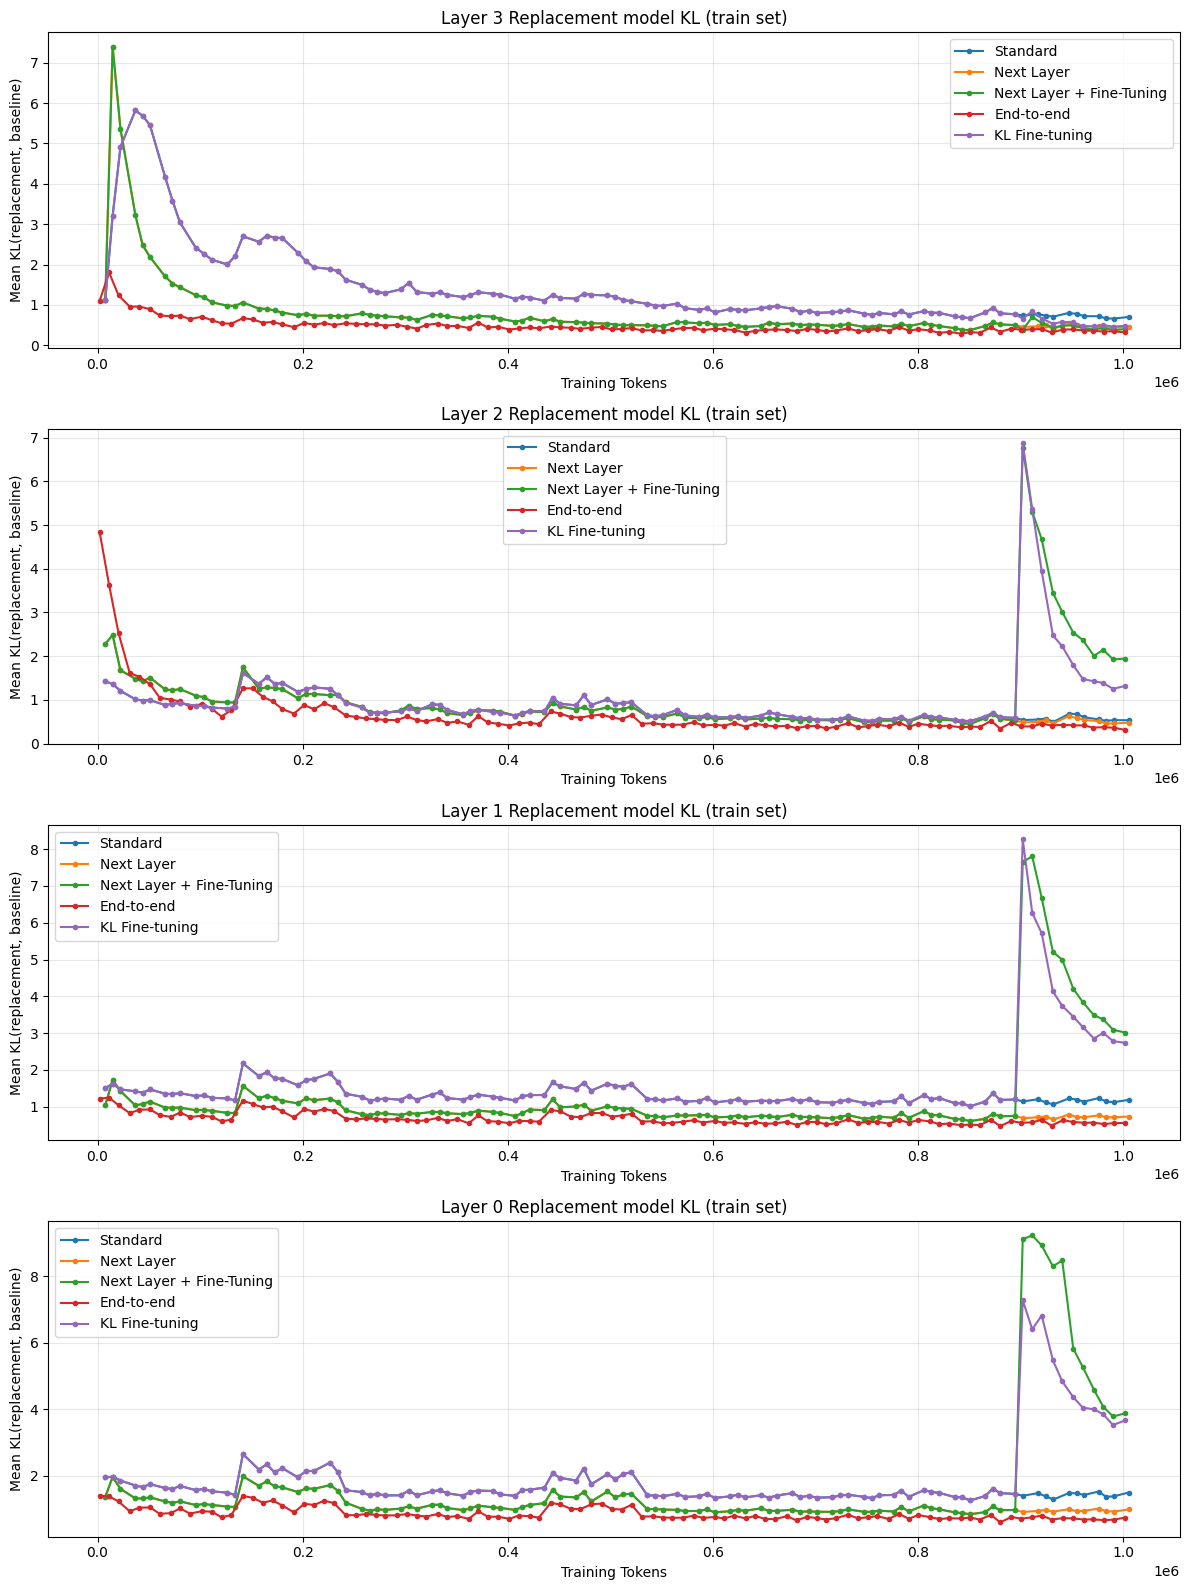

In [43]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(model.config.num_layers, 1, figsize=(12, 4 * model.config.num_layers))

for i, layer in enumerate(range(model.config.num_layers - 1, -1, -1)):
    ax = axes[i]
    
    for method in training_results:
        data = training_results[method][layer]['rep_kl']
        if data:
            tokens, kl_values = zip(*data)
            ax.plot(tokens, kl_values, label=method.value, marker='o', markersize=3)

    ax.set_xlabel('Training Tokens')
    ax.set_ylabel('Mean KL(replacement, baseline)')
    ax.set_title(f'Layer {layer} Replacement model KL (train set)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


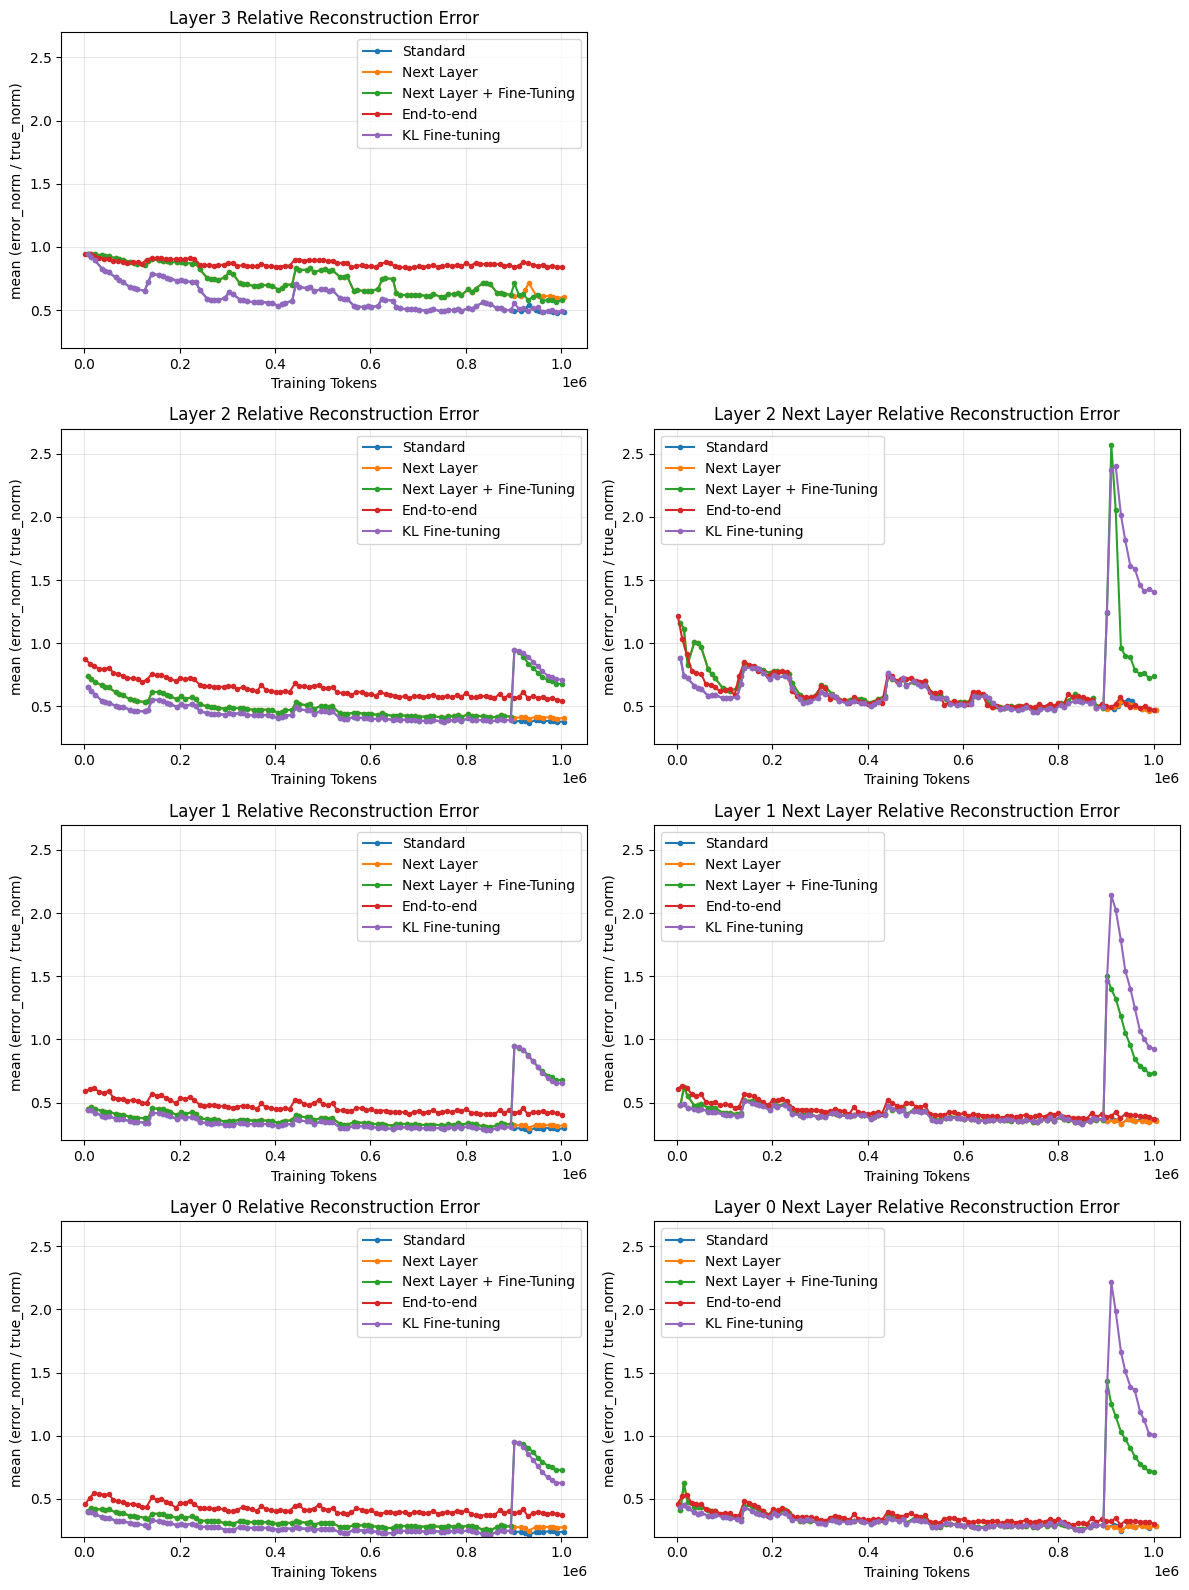

In [44]:
fig, axes = plt.subplots(model.config.num_layers, 2, figsize=(12, 4 * model.config.num_layers))

# Collect all rcn and next_rcn values to determine consistent y-axis limits
all_rcn_values = []
all_next_rcn_values = []

for layer in range(model.config.num_layers):
    for method in training_results:
        # Collect rcn values
        rcn_data = training_results[method][layer]['rcn']
        if rcn_data:
            _, rcn_values = zip(*rcn_data)
            all_rcn_values.extend(rcn_values)
        
        # Collect next_rcn values
        if layer < model.config.num_layers - 1:
            next_rcn_data = training_results[method][layer]['next_rcn']
            if next_rcn_data:
                _, next_rcn_values = zip(*next_rcn_data)
                all_next_rcn_values.extend(next_rcn_values)

# Calculate consistent y-axis limits for both rcn and next_rcn
all_values = all_rcn_values + all_next_rcn_values
y_min, y_max = min(all_values), max(all_values)

for i, layer in enumerate(range(model.config.num_layers - 1, -1, -1)):
    # Plot rcn (relative reconstruction norm)
    ax1 = axes[i, 0]
    for method in training_results:
        data = training_results[method][layer]['rcn']
        if data:
            tokens, rcn_values = zip(*data)
            ax1.plot(tokens, rcn_values, label=method.value, marker='o', markersize=3)

    ax1.set_xlabel('Training Tokens')
    ax1.set_ylabel('mean (error_norm / true_norm)')
    ax1.set_title(f'Layer {layer} Relative Reconstruction Error')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(y_min * 0.95, y_max * 1.05)

    # Plot next_rcn (next layer relative reconstruction norm)
    if layer < model.config.num_layers - 1:
        ax2 = axes[i, 1]
        for method in training_results:
            data = training_results[method][layer]['next_rcn']
            if data:
                tokens, next_rcn_values = zip(*data)
                ax2.plot(tokens, next_rcn_values, label=method.value, marker='o', markersize=3)

        ax2.set_xlabel('Training Tokens')
        ax2.set_ylabel('mean (error_norm / true_norm)')
        ax2.set_title(f'Layer {layer} Next Layer Relative Reconstruction Error')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(y_min * 0.95, y_max * 1.05)
    else:
        axes[i, 1].set_visible(False)

plt.tight_layout()
plt.show()


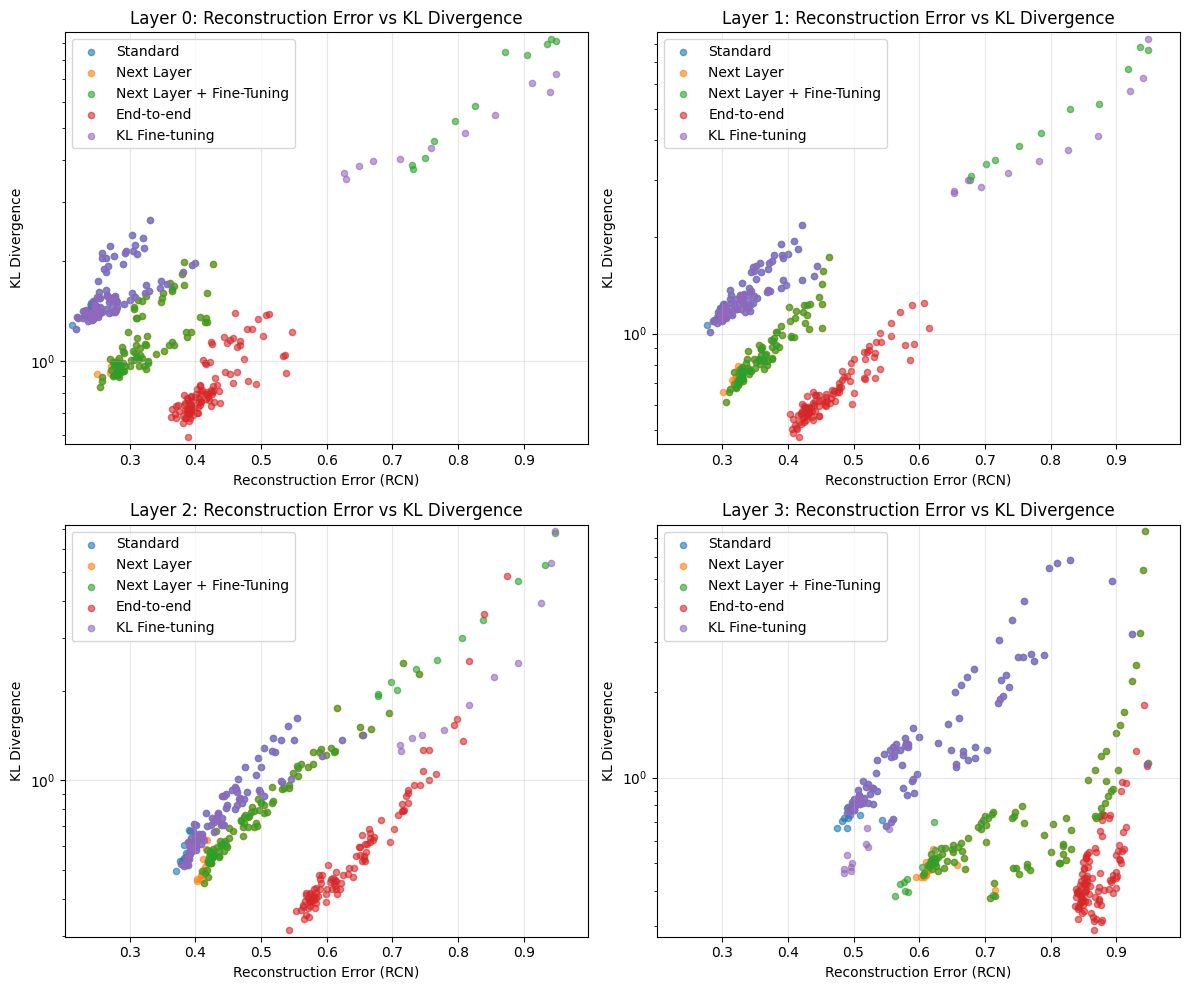

In [45]:
# Plot reconstruction error vs KL divergence for each layer separately
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Collect all RCN values across all layers and methods to determine global x-axis limits
all_rcn_values = []
for layer in range(model.config.num_layers):
    for method in training_results.keys():
        rcn_data = training_results[method][layer]['rcn']
        _, rcn_values = zip(*rcn_data)
        all_rcn_values.extend(rcn_values)

# Calculate global x-axis limits
global_rcn_min, global_rcn_max = min(all_rcn_values), max(all_rcn_values)

for layer in range(model.config.num_layers):
    ax = axes[layer]
    
    # Collect all KL values for this layer to determine y-axis limits
    layer_kl_values = []
    for method in training_results.keys():
        kl_data = training_results[method][layer]['rep_kl']
        _, kl_values = zip(*kl_data)
        layer_kl_values.extend(kl_values)
    
    # Calculate layer-specific y-axis limits
    kl_min, kl_max = min(layer_kl_values), max(layer_kl_values)
    
    for method in training_results.keys():
        # Get reconstruction error (rcn) and KL divergence for this layer
        rcn_data = training_results[method][layer]['rcn']
        kl_data = training_results[method][layer]['rep_kl']
        
        # Extract values from the (tokens, value) tuples
        _, rcn_values = zip(*rcn_data)
        _, kl_values = zip(*kl_data)
        
        # Create scatter plot
        ax.scatter(rcn_values, kl_values, alpha=0.6, s=20, 
                  label=f'{method.value}')

    ax.set_xlabel('Reconstruction Error (RCN)')
    ax.set_ylabel('KL Divergence')
    ax.set_title(f'Layer {layer}: Reconstruction Error vs KL Divergence')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Set consistent x-axis limits across all layers, layer-specific y-axis limits
    ax.set_xlim(global_rcn_min * 0.95, global_rcn_max * 1.05)
    ax.set_ylim(kl_min * 0.95, kl_max * 1.05)

    # Set log scale for better visualization
    ax.set_yscale('log')

plt.tight_layout()
plt.show()



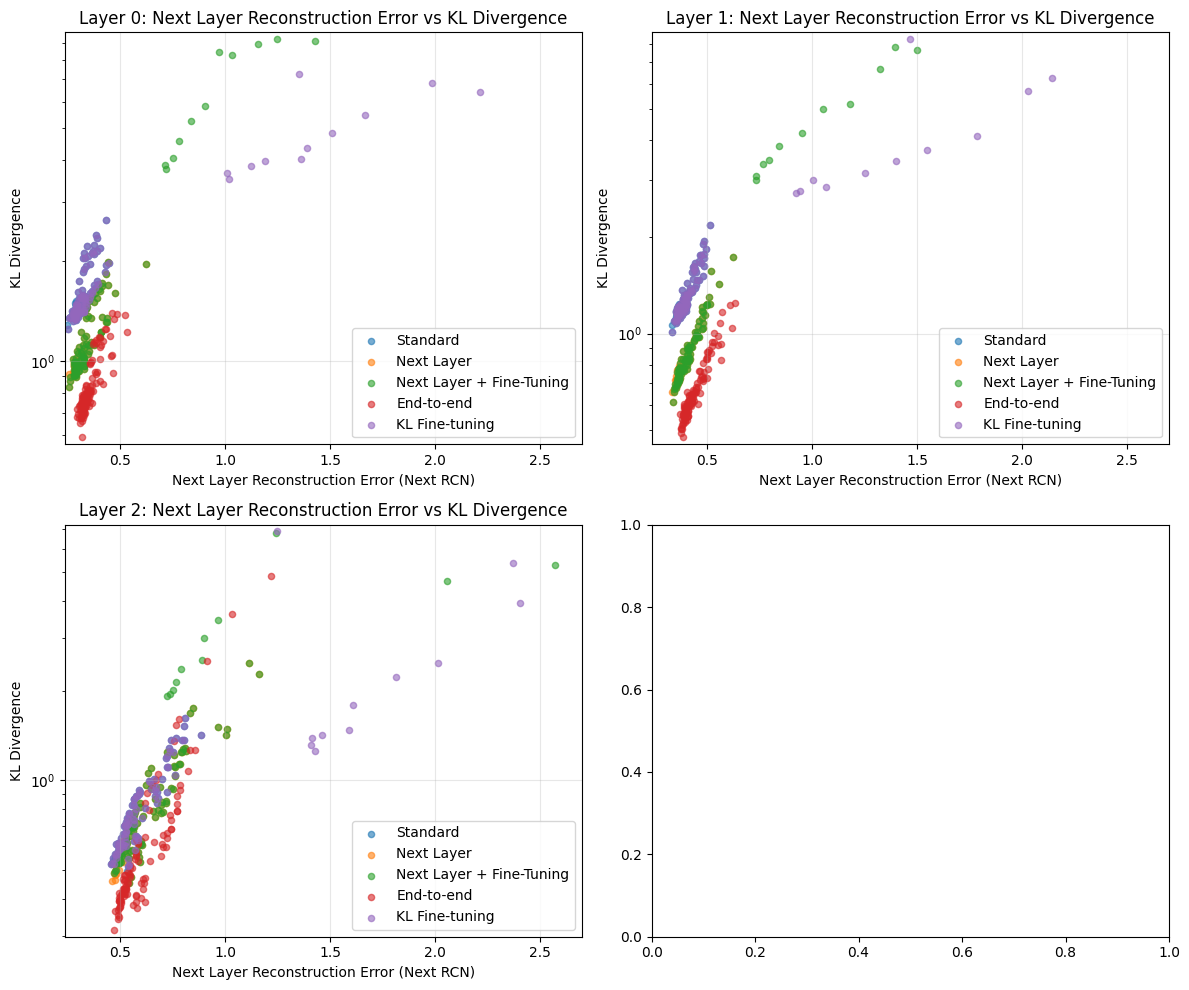

In [46]:
# Plot next_rcn vs KL divergence for each layer (skip final layer)
layers_to_plot = [layer for layer in training_results[list(training_results.keys())[0]].keys() if layer < max(training_results[list(training_results.keys())[0]].keys())]
num_layers = len(layers_to_plot)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Calculate global x-axis limits across all layers
all_next_rcn_values = []
for layer in layers_to_plot:
    for method in training_results.keys():
        next_rcn_data = training_results[method][layer]['next_rcn']
        _, next_rcn_values = zip(*next_rcn_data)
        all_next_rcn_values.extend(next_rcn_values)

global_next_rcn_min, global_next_rcn_max = min(all_next_rcn_values), max(all_next_rcn_values)

for i, layer in enumerate(layers_to_plot):
    ax = axes[i]
    
    # Collect all KL values for this layer to determine y-axis limits
    layer_kl_values = []
    for method in training_results.keys():
        kl_data = training_results[method][layer]['rep_kl']
        _, kl_values = zip(*kl_data)
        layer_kl_values.extend(kl_values)
    
    # Calculate layer-specific y-axis limits
    kl_min, kl_max = min(layer_kl_values), max(layer_kl_values)
    
    for method in training_results.keys():
        # Get next layer reconstruction error (next_rcn) and KL divergence for this layer
        next_rcn_data = training_results[method][layer]['next_rcn']
        kl_data = training_results[method][layer]['rep_kl']
        
        # Extract values from the (tokens, value) tuples
        _, next_rcn_values = zip(*next_rcn_data)
        _, kl_values = zip(*kl_data)
        
        # Create scatter plot
        ax.scatter(next_rcn_values, kl_values, alpha=0.6, s=20, 
                  label=f'{method.value}')

    ax.set_xlabel('Next Layer Reconstruction Error (Next RCN)')
    ax.set_ylabel('KL Divergence')
    ax.set_title(f'Layer {layer}: Next Layer Reconstruction Error vs KL Divergence')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Set consistent x-axis limits across all layers, layer-specific y-axis limits
    ax.set_xlim(global_next_rcn_min * 0.95, global_next_rcn_max * 1.05)
    ax.set_ylim(kl_min * 0.95, kl_max * 1.05)

    # Set log scale for better visualization
    ax.set_yscale('log')

plt.tight_layout()
plt.show()


## Validation set evals

In [50]:
from tiny_stories_sae.validation import validate_saes

validation_evals = {}
replacement_evals = {}
position_ids = {}
training_config["next_layer_finetune"] = training_config[TrainingMethod.next_layer]
for method in training_results.keys():
    validation_evals[method], replacement_evals[method], position_ids[method] = (
        validate_saes(
            model,
            tokenizer,
            saes[method],
            validation_dataset,
            num_tokens=NUM_VALIDATION_TOKENS,
            tokenizer_batch_size=training_config[method].tokenizer_batch_size,
            inference_batch_size=training_config[method].training_batch_size,
            cache_dir=VALIDATION_CACHE_DIR,
        )
    )

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

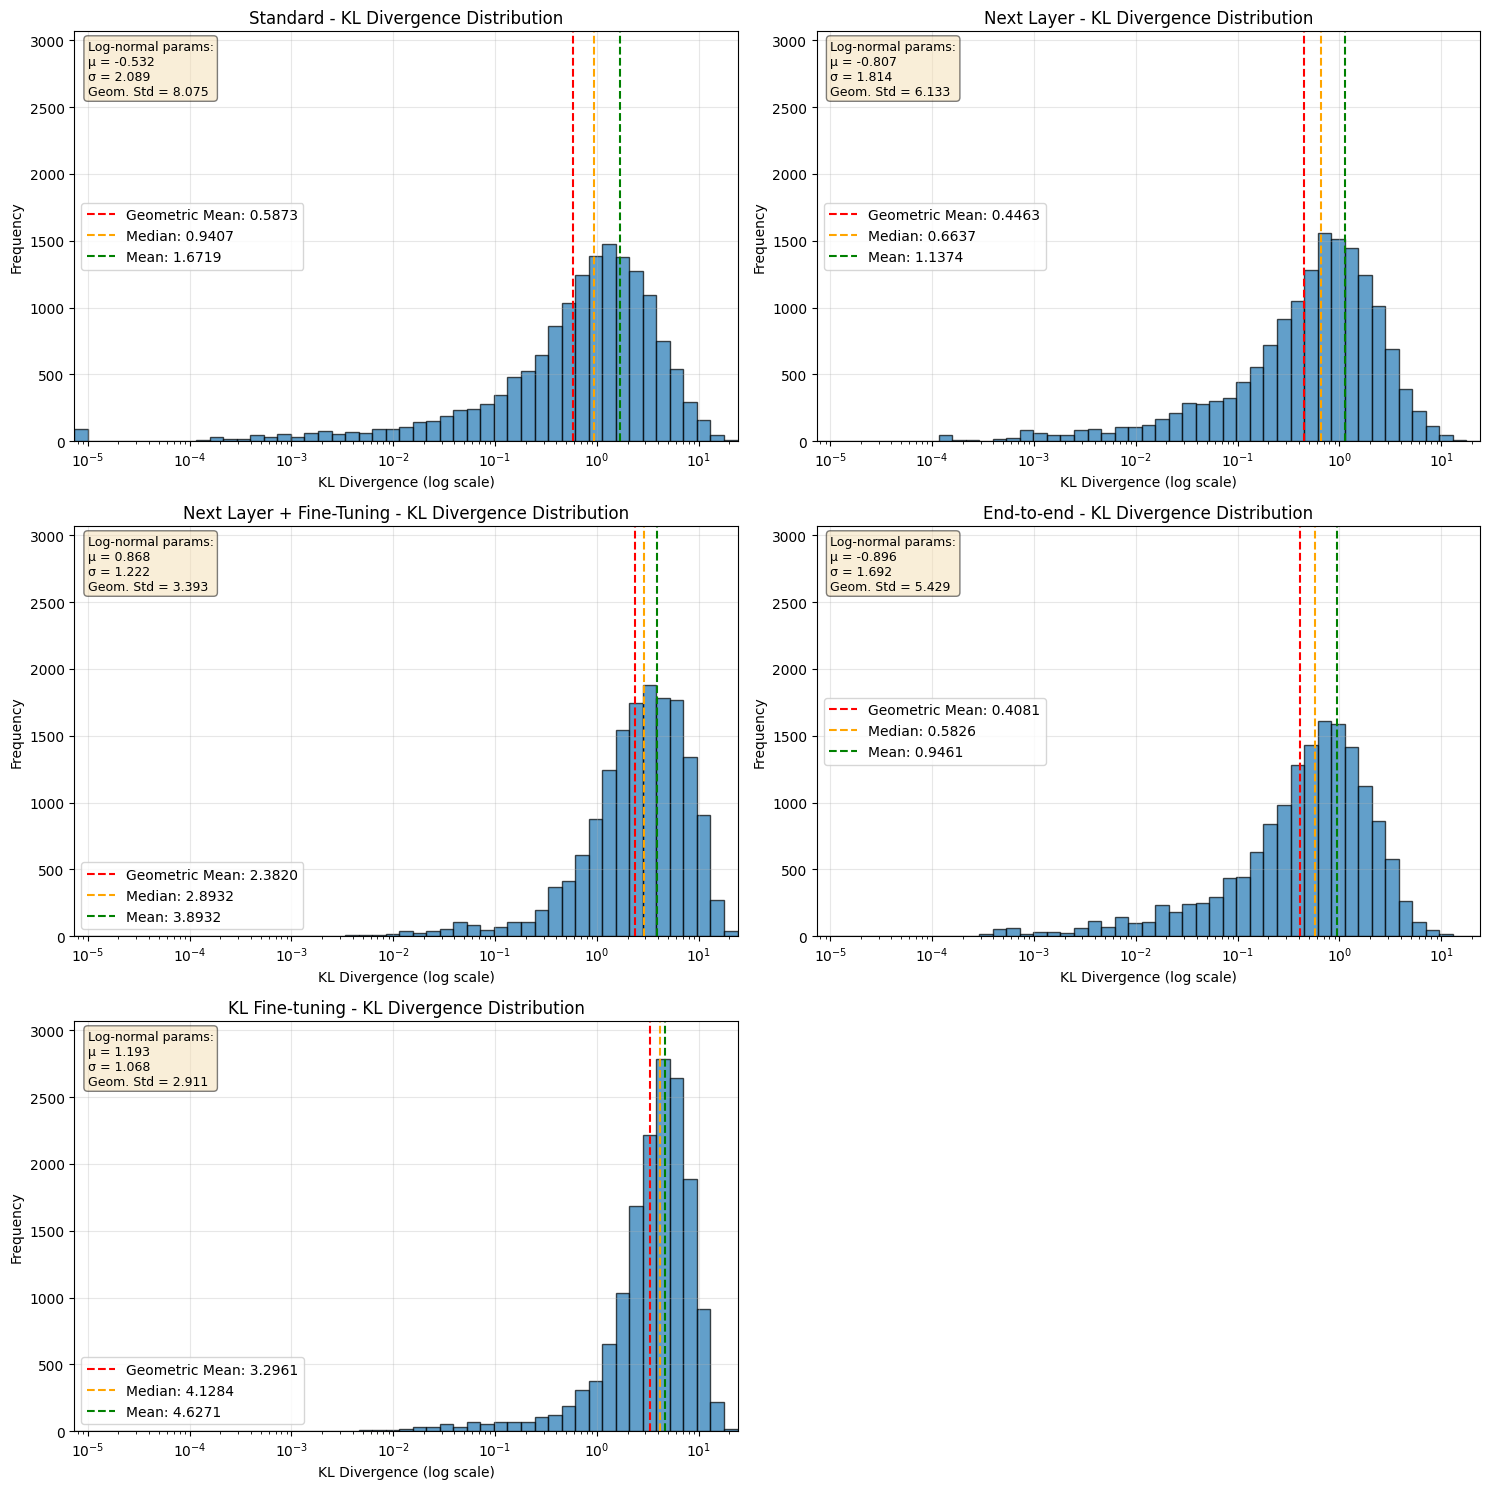

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Plot histograms of KL divergence for each method
num_methods = len(list(replacement_evals.keys()))
ncols = 2
nrows = (num_methods + ncols - 1) // ncols  # Ceiling division

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))

# Handle case where we have only one row
if nrows == 1:
    axes = axes.reshape(1, -1)
# Handle case where we have only one method
if num_methods == 1:
    axes = axes.reshape(-1)

# Calculate global min/max for consistent bins across all methods
all_kl_values = []
for method in replacement_evals.keys():
    kl_values = replacement_evals[method]["kl"]
    all_kl_values.extend(kl_values[kl_values > 0])

global_min = np.min(all_kl_values)
global_max = np.max(all_kl_values)
log_bins = np.logspace(np.log10(global_min), np.log10(global_max), 50)

# Calculate global y-axis limits
max_frequency = 0
for method in replacement_evals.keys():
    kl_values = replacement_evals[method]["kl"]
    counts, _ = np.histogram(kl_values, bins=log_bins)
    max_frequency = max(max_frequency, np.max(counts))

for i, method in enumerate(replacement_evals.keys()):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]
    
    kl_values = replacement_evals[method]["kl"]

    # Create histogram with consistent bins
    ax.hist(kl_values, bins=log_bins, alpha=0.7, edgecolor="black")
    ax.set_xscale("log")
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(0, max_frequency * 1.1)
    ax.set_xlabel("KL Divergence (log scale)")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{method.value} - KL Divergence Distribution")
    ax.grid(True, alpha=0.3)

    # Compute log-normal distribution statistics
    log_kl_values = np.log(kl_values[kl_values > 0])
    log_mean = np.mean(log_kl_values)
    log_std = np.std(log_kl_values)
    
    # Geometric mean and geometric standard deviation for log-normal distribution
    geometric_mean = np.exp(log_mean)
    geometric_std = np.exp(log_std)
    
    # Median is the same as geometric mean for log-normal
    median_kl = np.median(kl_values)
    
    # Arithmetic mean
    mean_kl = np.mean(kl_values)
    
    ax.axvline(geometric_mean, color="red", linestyle="--", label=f"Geometric Mean: {geometric_mean:.4f}")
    ax.axvline(
        median_kl, color="orange", linestyle="--", label=f"Median: {median_kl:.4f}"
    )
    ax.axvline(
        mean_kl, color="green", linestyle="--", label=f"Mean: {mean_kl:.4f}"
    )
    
    # Add text box with log-normal parameters
    textstr = f'Log-normal params:\nμ = {log_mean:.3f}\nσ = {log_std:.3f}\nGeom. Std = {geometric_std:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)
    
    ax.legend()

# Hide any unused subplots
for i in range(num_methods, nrows * ncols):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [53]:
from tiny_stories_sae.validation import generate_with_replacement
from IPython.display import HTML

# Generate completions with and without SAE replacement
prompt = "Once upon a time"
sample_generations = {}

# Generate without replacement (baseline)
print("Generating baseline completion...")
baseline_tokens = generate_with_replacement(
    model, tokenizer, prompt, saes={}, do_sample=False, stream=False
)
sample_generations["Baseline"] = tokenizer.decode(baseline_tokens[0], skip_special_tokens=True)

# # Generate with each SAE method
for method in TrainingMethod:
    print(f"Generating completion with {method.value}...")
    method_tokens = generate_with_replacement(
        model,
        tokenizer,
        prompt,
        saes=saes[method],
        do_sample=False,
        stream=False,
    )
    sample_generations[method.value] = tokenizer.decode(method_tokens[0], skip_special_tokens=True)

# Display results in HTML table
html_table = """
<table border="1" style="border-collapse: collapse; width: 100%;">
<tr style="background-color: #f2f2f2;">
<th style="padding: 10px; text-align: left;">Method</th>
<th style="padding: 10px; text-align: left;">Generated Text</th>
</tr>
"""

for method_name, text in sample_generations.items():
    html_table += f"""
<tr>
<td style="padding: 10px; vertical-align: top; font-weight: bold;">{method_name}</td>
<td style="padding: 10px; font-family: monospace; white-space: pre-wrap;">{text}</td>
</tr>
"""

html_table += "</table>"

display(HTML(html_table))


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating baseline completion...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with Standard...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with Next Layer...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with End-to-end...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with KL Fine-tuning...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with Next Layer + Fine-Tuning...


Method,Generated Text
Baseline,"Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine. One day, she saw a big, red apple on the ground. She picked it up and took a bite. It was so juicy and delicious! Suddenly, she heard a loud noise. It was a big, scary dog! Lily was scared and didn't know what to do. But then, she remembered the apple she had picked earlier. She took a bite and it was even more delicious than before! Lily learned that sometimes things that look scary can be delicious. She also learned that it's important to be brave and not give up. From that day on, Lily always carried an apple with her, just in case she needed to face her fears."
Standard,"Once upon a time, there was a little girl named Lily. She loved to play with her toys and make things. One day, she went to the park with her mom. She saw a big, scary monster. She was scared and started to cry. Her mom said, ""Don't worry, I'm going to help you."" She said, ""Let's go back to the park to find something special."" When they arrived, they saw a big, scary monster. The monster was grow and it was very scary. Lily was scared. She started to cry. The next day, Lily and her mom went to the park. They saw a big, scary monster. They were walking around the park. They ran to the park and saw a big, scary monster coming out of the bushes. Lily's mom said, ""Don't worry, we can make it!"" The monster was angry and ran away. Lily and her mom ran away, but the park was too late. The park was gone. They were scared and they were sad. They never found the monster and the park. The end."
Next Layer,"Once upon a time, there was a little girl named Lily. She loved to play outside in the park with her friends. One day, Lily's friend, Max, asked her to go for a walk in the park. Lily said, ""Yes, I want to go to the park."" But Max said, ""I can't go. I'm sorry. I'm sorry."" Lily said, ""Don't worry, Max. I can help you. Let's go for a walk."" Max and Lily walked to the park and they saw a big, dark forest. They saw a big, dark mountain with lots of trees and flowers. They decided to climb the mountain and look at the mountain. They saw a big, dark cave and they saw a big, dark monster. Lily said, ""Lily, let's go inside. I'm sorry. I'm sorry. I'm sorry. I'm sorry."" Lily said, ""It's okay, Lily. You can go in the cave. Let's go home."" Lily and Max walked home, and they both were happy to have a lot of fun in the forest."
End-to-end,"Once upon a time, there was a little girl named Lily. She loved to play with her toys all around her house. One day, Lily's mommy asked her to help her with her mommy. She was very excited to help her mommy. Lily's mommy asked, ""What are you doing, Lily?"" Lily replied, ""Mommy, can I help you with the stove?"" Her mommy said, ""Yes, I can help you put the stove in the sink and we can cook it together. It will make hot smells like sweet smells. Lily was so happy to help her mommy. She loved to help her mommy and make yummy things. She loved to help her mommy and daddy and play with her toys. She was so helpful and loved to help her mommy in the garden and play with her toys. The end."
KL Fine-tuning,"Once upon a time, she had been so tough. She finished by that time, even. After that day ever. After that day ever, ever. From. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. End. *. End. End. End. End. End. End. *. End. End. *. End. End. *. *. End. *. End. *. *. End. *. End. *. *. End. *. End. *. End. *. End. *. '. *. *. *. *. *. *. *.. *. *. *. *...... '.. '...... *. *... *.. End..... '... '............. '...................................................................................................................................................................................................................

# Save training runs

In [ ]:
# from tiny_stories_sae.ops import save_demo_run

# save_demo_run(
#     "/tmp/cossim_next",
#     saes,
#     training_config,
#     training_results,
#     validation_evals,
#     replacement_evals,
# )


In [ ]:
# from tiny_stories_sae.ops import load_demo_run

# saes, training_config, training_results, validation_evals, replacement_evals = (
#     load_demo_run(
#         "/tmp/demo_runs/tiny_stories_demo/",
#         # TODO: obviously we should have been persisting these in something like an SAEConfig class
#         (
#             D_MODEL,
#             D_SAE,
#         ),
#         dict(
#             device=TRAINING_DEVICE,
#             kind="topk",
#             topk=100,
#         ),
#     )
# )